# Part 1

## Imports

In [ ]:
!pip install jedi --quiet
!pip install snntorch --quiet
!pip install brevitas --quiet

In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen
from snntorch import spikeplot as splt
from snntorch.functional import quant

import brevitas.nn as qnn

import torch
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [ ]:
base_path = '/content/drive/My Drive/project_aug/v4'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose([
            transforms.Resize((14,14)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

test_data = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

num_workers=0
batch_size=50
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

print(f"Test data size : {test_loader.dataset.__len__()}")

Test data size : 10000


## Architecture

In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 1

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, in_channels, out_channels, kernal_size, padding, use_pool=False):
    super(ConvNet,self).__init__()
    # self.conv=nn.Conv2d(in_channels,out_channels,kernal_size,padding=padding)
    self.conv = qnn.QuantConv2d(in_channels, out_channels, kernal_size, padding=padding, bias=False, weight_bit_width=8)
    self.use_pool = use_pool
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.activation= nn.ReLU()

  def forward(self,data):
    if self.use_pool:
      return self.activation(self.pool(self.conv(data)));
    else:
      return self.activation(self.conv(data));


In [ ]:
class SnnNet(nn.Module):
  def __init__(self,num_steps,in_channels=8,out_channels=16, use_pool=False):
    super(SnnNet,self).__init__()
    self.use_pool = use_pool
    self.num_steps = num_steps

    qlif = quant.state_quant(num_bits=8, uniform=False, thr_centered=True)

    # self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1)
    self.conv = qnn.QuantConv2d(in_channels, out_channels, kernel_size=3,padding=0,stride=1, bias=False, weight_bit_width=8)
    # self.lif1 = snn.Leaky(beta=beta, state_quant=qlif)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.activation = snn.Leaky(beta=beta, spike_grad=spike_grad, state_quant=qlif, reset_mechanism = "zero")

  def forward(self,data):
    self.activation.reset_mem()
    out = []
    mems_out = []
    for step in range(self.num_steps):
      output = self.conv(data[step])
      spike_out, mem_out = self.activation(output)

      if self.use_pool:
        spike_out = self.pool(spike_out);
        mem_out = self.pool(mem_out);

      out.append(spike_out)
      mems_out.append(mem_out)

    return torch.stack(out,dim=0), torch.stack(mems_out,dim=0)
    # return torch.sum(snn_out, dim=0)


In [ ]:
class Net(nn.Module):
  def __init__(self,num_steps=0, use_spike=False):
    super(Net,self).__init__()
    self.use_spike = use_spike
    self.num_steps = num_steps
    self.mainArch = self.createNet()
    self.fcs = self.createfcs()
    self.layer1_output = None
    self.spike_encoded_input = None
    self.layer2_output_spk = None
    self.layer2_output_mem = None
    self.layer2_output = None
    self.spike_output = None

  def createNet(self):
    layers = [ConvNet(1,8,5,0, True)]
    if self.use_spike:
      layers.append(SnnNet(num_steps=self.num_steps,use_pool=False))
    else:
      layers.append(ConvNet(8,16,3,0,use_pool=False))

    layers.append(ConvNet(16,16,1,0, False))
    return nn.Sequential(*layers)

  def createfcs(self):
    return nn.Sequential(
        nn.Dropout(0.2),
        qnn.QuantLinear(3*3*16,512, bias=True, weight_bit_width=8),
        nn.ReLU(),
        nn.Dropout(0.2),
        qnn.QuantLinear(512,256, bias=True, weight_bit_width=8),
        nn.ReLU(),
        nn.Dropout(0.2),
        qnn.QuantLinear(256,10, bias=True, weight_bit_width=8)
    )

  def forward(self, data):
    x= data
    self.layer1_output = self.mainArch[0](x)
    if self.use_spike:   # Spike encoding on the output of the first layer
      self.spike_encoded_input = spikegen.rate(self.layer1_output, self.num_steps)
      self.layer2_output, self.layer2_output_mem = self.mainArch[1](self.spike_encoded_input)
      self.spike_output = self.layer2_output
      self.layer2_output = torch.sum(self.layer2_output, dim=0)
    else:
      self.layer2_output = self.mainArch[1](self.layer1_output)
    x = self.mainArch[2](self.layer2_output)
    x = x.view(-1, 3 * 3 * 16)
    return self.fcs(x)


## Load the model

In [ ]:
scnn_model = Net(num_steps=3,use_spike=True)

In [ ]:
scnn_model_path = base_path + '/model/Net_scnn_frz2_quant8b_model.pth'
scnn_state_dict = torch.load(scnn_model_path, map_location=torch.device('cpu'))
scnn_model.load_state_dict(scnn_state_dict, False)
scnn_model.eval()
print()

## Pick an Image



```

    Get a random image by its label from the test loader.

    Parameters:
    - loader (DataLoader): The DataLoader from which to fetch the image.
    - label (int): The label of the image to fetch.

    Returns:
    - image (Tensor): The image tensor.
```

In [ ]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

def get_random_image_by_label(loader, label):

    images = []
    labels = []

    # Collect all images with the specified label
    for batch_images, batch_labels in loader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)

    if not images:
        raise ValueError(f"No images found with label {label}")

    # Choose a random image
    idx = random.randint(0, len(images) - 1)
    selected_image = images[idx]

    # Display the image
    plt.imshow(selected_image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}, {fashion_class[label]}")
    plt.show()

    return selected_image, idx


## Inference pass

Might not be able to extract INT weights here. so extract fp32 non-qunatized weights

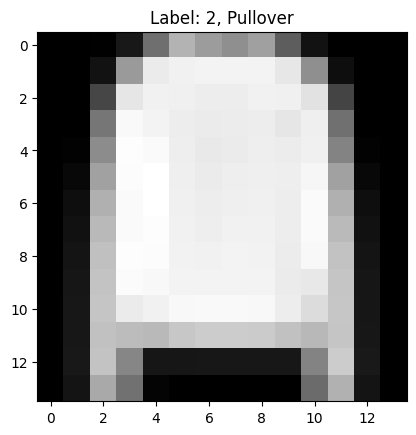

In [ ]:
random_image, idx = get_random_image_by_label(test_loader, 2)

scnn_model.eval()
with torch.no_grad():
  spk_rec  = scnn_model(random_image)       # Pass the random image to the model

predicted = spk_rec[-1].max(0, keepdim=True)[1]



layer1_output = scnn_model.layer1_output
spike_encoded_input = scnn_model.spike_encoded_input
spike_output = scnn_model.spike_output
spike_encoded_input.shape

np.save(base_path + '/input_output/in_spk_' + str(idx)+ '.npy', random_image.numpy())
# np.save(base_path + '/input_output/in_spk.npy', spike_encoded_output.numpy())
# np.save(base_path + '/input_output/out_spk.npy', layer2_output.numpy())

In [ ]:
print(f"Predicted class: {predicted}")

Predicted class: tensor([2])


# Part 2

### Weights
Non_quantized_float, quantized_float, quantized_int weights

In [ ]:
for name, module in scnn_model.named_modules():
    if isinstance(module, qnn.QuantConv2d) and 'mainArch.1.conv' in name:
        print(name)
        fp32_weights = module.weight.detach().cpu().numpy()     # Non qunatized weight
        break

quant_weight_float = np.load(base_path + '/model_weights/quant_weight_float.npy')
quant_weight_int = np.load(base_path + '/model_weights/quant_weight_int.npy')

# print(fp32_weights.shape)
# print(quant_weight_float.shape)
print(quant_weight_int.shape)


mainArch.1.conv
(16, 8, 3, 3)


### Functions

In [ ]:
def save_output_for_vhdl(output, file_path):
    with open(file_path + '.txt', 'w') as f:
        total_elements = output.numel()
        zero_elements = torch.sum(output == 0).item()
        sparsity = (zero_elements / total_elements) *100
        f.write(f"Sparsity: {sparsity}\n")

        output_np = output.detach().cpu().numpy()
        num_channels = output_np.shape[0]

        for channel_idx in range(num_channels):
            channel_data = output_np[channel_idx, :, :]
            f.write(f"Channel {channel_idx}:\n")
            np.savetxt(f, channel_data, fmt='%.6f')
            f.write("\n")

        # Save output as numpy file
        np.save(file_path + '.npy', output_np)

### LIF

In [ ]:
output_path = base_path + '/input_output/'
os.makedirs(output_path, exist_ok=True)

for step in range(spike_encoded_input.shape[0]):
    in_spk_file_path = os.path.join(output_path, 'in_spk_8b'+ str(step))
    save_output_for_vhdl(spike_encoded_input[step], in_spk_file_path)

for step in range(spike_output.shape[0]):
  out_spk_file_path = os.path.join(output_path, 'out_spk_8b'+ str(step))
  save_output_for_vhdl(spike_output[step], out_spk_file_path)

In [ ]:
def apply_lif_neurons(input_data, weights, threshold= 1.0, beta=1, reset_value=0.0):
    # Assuming input_data shape is (time, channels, height, width)
    time_steps = input_data.shape[0]

    # Determine output shape after convolution
    output_shape = (time_steps, weights.shape[0],  # (time, output_channels, height, width)
                    input_data.shape[2] - weights.shape[2] + 1,
                    input_data.shape[3] - weights.shape[3] + 1)

    # if isinstance(thresholds, (float, int)):
    #     thresholds = np.full(time_steps, thresholds)  # If a single threshold is given, replicate it across all timesteps

    # Initialize output spikes
    output_spikes = np.zeros(output_shape)  # Shape: (time, output_channels, height, width)


    # Initialize membrane potential for this timestep
    membrane_potential = np.zeros((time_steps, weights.shape[0], output_shape[2], output_shape[3]))  # Shape: (output_channels, height, width)

    # Perform convolution for the current timestep
    for out_channel in range(output_shape[1]):
        for i in range(output_shape[2]):
            for j in range(output_shape[3]):
              for t in range(time_steps):
                # Calculate convolution output at this stride
                conv_output = np.sum(input_data[t, :, i:i+weights.shape[2], j:j+weights.shape[3]] * weights[out_channel])

                # Update membrane potential with leaky integration
                if t == 0:
                  membrane_potential[t, out_channel, i, j] = beta * membrane_potential[t, out_channel, i, j] + conv_output
                else:
                  membrane_potential[t, out_channel, i, j] = beta * membrane_potential[t-1, out_channel, i, j] + conv_output

                # Generate spike if membrane potential exceeds threshold
                if membrane_potential[t, out_channel, i, j] >= threshold:
                    output_spikes[t, out_channel, i, j] = 1
                    # Reset membrane potential where spike occurred
                    # membrane_potential[t,out_channel, i, j] = membrane_potential[t,out_channel, i, j]-threshold
                    membrane_potential[t,out_channel, i, j] = reset_value

    return output_spikes, membrane_potential


### Analysis

In [ ]:
# input_data = spike_encoded_input.numpy()
# output_spikes, membrane_potential = apply_lif_neurons(input_data, fp32_weights, threshold= 1.0)

# input_data = spike_encoded_input.numpy()
# output_spikes, membrane_potential = apply_lif_neurons(input_data, quant_weight_float, threshold= 1.0)

input_data = spike_encoded_input.numpy()
# output_spikes, membrane_potential = apply_lif_neurons(input_data, quant_weight_int, threshold= 101.0101)
output_spikes, membrane_potential = apply_lif_neurons(input_data, quant_weight_int, threshold= 101)

In [ ]:
print(output_spikes[2])

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [1. 0. 0.]
  [0. 0. 1.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 1. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 1.]
  [0. 0. 0.]]

 [[0. 1. 0.]
  [1. 1. 0.]
  [0. 1. 1.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 0. 1.]
  [1. 0. 1.]
  [1. 0. 1.]]

 [[1. 1. 0.]
  [1. 1. 0.]
  [1. 1. 0.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [ ]:
def conv_results(row, col, channel):
  conv_output = input_data[0, :, row:row+quant_weight_int.shape[2], col:col+quant_weight_int.shape[3]] * quant_weight_int[channel]
  print(np.sum(conv_output))
  conv_output = input_data[1, :, row:row+quant_weight_int.shape[2], col:col+quant_weight_int.shape[3]] * quant_weight_int[channel]
  print(np.sum(conv_output))
  conv_output = input_data[2, :, row:row+quant_weight_int.shape[2], col:col+quant_weight_int.shape[3]] * quant_weight_int[channel]
  print(np.sum(conv_output))

conv_results(1, 1, 14)

# conv_output = input_data[1, :, 2:2+quant_weight_int.shape[2], 2:2+quant_weight_int.shape[3]] * quant_weight_int[0]
# # print(conv_output)
# print(np.sum(conv_output))

22.0
-31.0
21.0


In [ ]:
# print(membrane_potential[1])

In [ ]:
print(np.array_equal(output_spikes[0], spike_output[0]))

True


In [ ]:
print(np.array_equal(output_spikes[1], spike_output[1]))

True


In [ ]:
print(np.array_equal(output_spikes[2], spike_output[2]))

True


# Part3

## Format weights

In [ ]:
# Path to the directory where you want to save the file
save_dir = base_path + '/model_weights/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
qweights_file_path = os.path.join(save_dir, 'scnn_quant8b_weight_int.txt')

# Save the weights to the text file in Google Drive
with open(qweights_file_path, 'w') as f:
  out_channels, in_channels, kernel_height, kernel_width = quant_weight_int.shape
  f.write(f"#{name}\n")
  f.write(f"#{quant_weight_int.shape}\n")
  for out_ch in range(out_channels):
      for in_ch in range(in_channels):
          f.write(f"Kernel {out_ch}-{in_ch}:\n")
          kernel_weights = quant_weight_int[out_ch, in_ch]
          for row in kernel_weights:
              f.write(' '.join(map(str, row)) + '\n')
          f.write('\n')

print(f"Weights saved to {qweights_file_path}")

Weights saved to /content/drive/My Drive/project_aug/v4/model_weights/scnn_quant8b_weight_int.txt
